### 1. Importaciones y congiguración

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, f1_score, precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### 2. Carga y preparación de datos

In [4]:
# Cargar dataset único
df = pd.read_csv('/content/drive/MyDrive/Analisis Predictivo/TREVISAN_Examen_Final_Predictivo/loan_data.csv')
print(f"Dataset cargado: {df.shape}")
print(f"\nColumnas disponibles:")
print(df.columns.tolist())

Dataset cargado: (45000, 14)

Columnas disponibles:
['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status']


In [5]:
# Verificar variable objetivo
print(f"Distribución de la variable objetivo:")
print(df['loan_status'].value_counts(normalize=True))
print(f"Balance de clases: {df['loan_status'].value_counts().min() / df['loan_status'].value_counts().max():.2f}")

# La variable objetivo presenta desbalance: ~78% clase 0 y ~22% clase 1.
# Esto implica que la accuracy puede ser engañosa, ya que predecir siempre la clase mayoritaria
# daría un buen resultado sin capturar correctamente la clase minoritaria.
# Por este motivo, se utilizan métricas alternativas que evalúan mejor el desempeño del modelo.


Distribución de la variable objetivo:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64
Balance de clases: 0.29


In [6]:
# Información básica del dataset
print(f"Información del dataset:")
print(f"- Total de registros: {len(df)}")
print(f"- Defaults: {df['loan_status'].sum()} ({df['loan_status'].mean()*100:.2f}%)")
print(f"- Pagados: {(df['loan_status']==0).sum()} ({(1-df['loan_status'].mean())*100:.2f}%)")
print(f"- Valores faltantes: {df.isnull().sum().sum()}")

Información del dataset:
- Total de registros: 45000
- Defaults: 10000 (22.22%)
- Pagados: 35000 (77.78%)
- Valores faltantes: 0


### 3. Feature engineering

In [7]:
def prepare_features(df):
    """
    Preparación de features basada en hallazgos del EDA:
    - loan_percent_income (0.385) y loan_int_rate (0.332) son los más correlacionados
    - person_income (-0.169) es factor protector
    - Variables demográficas tienen correlación baja pero son relevantes
    """
    df = df.copy()

    # Features de interacción basadas en EDA
    df['income_to_loan_ratio'] = df['person_income'] / (df['loan_amnt'] + 1)
    df['debt_burden'] = df['loan_percent_income'] * df['loan_int_rate']
    df['credit_to_income'] = df['credit_score'] * df['person_income'] / 100000
    df['exp_to_age_ratio'] = df['person_emp_exp'] / (df['person_age'] + 1)

    # Binning de variables continuas
    df['age_group'] = pd.cut(df['person_age'], bins=[0, 25, 35, 50, 100],
                              labels=['young', 'adult', 'middle', 'senior'])
    df['income_level'] = pd.qcut(df['person_income'], q=4,
                                  labels=['low', 'medium', 'high', 'very_high'], duplicates='drop')
    df['credit_category'] = pd.cut(df['credit_score'],
                                    bins=[0, 580, 670, 740, 850],
                                    labels=['poor', 'fair', 'good', 'excellent'])

    # Encoding de variables categóricas
    categorical_cols = ['person_gender', 'person_education', 'person_home_ownership',
                       'loan_intent', 'previous_loan_defaults_on_file',
                       'age_group', 'income_level', 'credit_category']

    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))

    return df

In [8]:
# Aplicar feature engineering
df_fe = prepare_features(df)

print("Feature engineering completado")
print(f"Total de features: {df_fe.shape[1]}")

Feature engineering completado
Total de features: 29


### 4. Partición de datos

In [9]:
# Seleccionar features para el modelo
feature_cols = [
    # Features originales más importantes según EDA
    'loan_percent_income', 'loan_int_rate', 'person_income', 'loan_amnt',
    'credit_score', 'person_age', 'person_emp_exp', 'cb_person_cred_hist_length',

    # Features engineered
    'income_to_loan_ratio', 'debt_burden', 'credit_to_income', 'exp_to_age_ratio',

    # Features categóricas encoded
    'person_gender_encoded', 'person_education_encoded',
    'person_home_ownership_encoded', 'loan_intent_encoded',
    'previous_loan_defaults_on_file_encoded',
    'age_group_encoded', 'income_level_encoded', 'credit_category_encoded'
]

In [10]:
# Preparar X e y
X = df_fe[feature_cols]
y = df_fe['loan_status']

In [11]:
# Imputar valores faltantes si existen
X = X.fillna(X.median())

In [12]:
# Split estratificado: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 x 0.8 = 0.2
)

print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# ROC-AUC es apropiado para problemas de clasificación binaria desbalanceados
# Mide la capacidad del modelo para discriminar entre clases
# Es independiente del umbral de clasificación

print("\nDistribución de clases:")
print(f"Train - Default rate: {y_train.mean()*100:.2f}%")
print(f"Validation - Default rate: {y_val.mean()*100:.2f}%")
print(f"Test - Default rate: {y_test.mean()*100:.2f}%")

Train: 27000 samples (60.0%)
Validation: 9000 samples (20.0%)
Test: 9000 samples (20.0%)

Distribución de clases:
Train - Default rate: 22.22%
Validation - Default rate: 22.22%
Test - Default rate: 22.22%


In [13]:
# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### 5. Modelo Baseline

In [14]:
# Baseline 1: Predicción por mayoría
baseline_majority = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_majority.fit(X_train, y_train)
baseline_maj_score = roc_auc_score(y_val, baseline_majority.predict_proba(X_val)[:, 1])


In [15]:
# Baseline 2: Predicción estratificada
baseline_stratified = DummyClassifier(strategy='stratified', random_state=42)
baseline_stratified.fit(X_train, y_train)
baseline_strat_score = roc_auc_score(y_val, baseline_stratified.predict_proba(X_val)[:, 1])


In [16]:
print(f"Baseline (Most Frequent): ROC-AUC = {baseline_maj_score:.4f}")
print(f"Baseline (Stratified): ROC-AUC = {baseline_strat_score:.4f}")
print(f"\n→ Cualquier modelo debe superar ROC-AUC de {baseline_strat_score:.4f}")

# Se evalúan baselines simples para establecer un piso de desempeño.
# El mejor baseline (stratified) obtiene ROC-AUC ≈ 0.505.
# Todo modelo candidato debe superar este valor para considerarse útil.


Baseline (Most Frequent): ROC-AUC = 0.5000
Baseline (Stratified): ROC-AUC = 0.5049

→ Cualquier modelo debe superar ROC-AUC de 0.5049


### 6. Selección de modelos

In [17]:
# Diccionario de modelos a probar
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

In [18]:
# Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")

    # Usar datos escalados para modelos lineales
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calcular métricas
    auc_score = roc_auc_score(y_val, y_pred_proba)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    results[name] = {
        'model': model,
        'auc': auc_score,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

    print(f"  ROC-AUC: {auc_score:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")

# Se entrenan y comparan distintos modelos de clasificación.
# Todos superan ampliamente el baseline (ROC-AUC ≈ 0.505),
# confirmando que capturan patrones relevantes del dataset.



Entrenando Logistic Regression...
  ROC-AUC: 0.9485
  F1-Score: 0.7310
  Precision: 0.6089
  Recall: 0.9145

Entrenando Decision Tree...
  ROC-AUC: 0.9418
  F1-Score: 0.7567
  Precision: 0.6668
  Recall: 0.8745

Entrenando Random Forest...
  ROC-AUC: 0.9694
  F1-Score: 0.8049
  Precision: 0.8844
  Recall: 0.7385

Entrenando Gradient Boosting...
  ROC-AUC: 0.9675
  F1-Score: 0.7961
  Precision: 0.8697
  Recall: 0.7340

Entrenando XGBoost...
  ROC-AUC: 0.9739
  F1-Score: 0.8229
  Precision: 0.8684
  Recall: 0.7820


In [19]:
# Resumen de resultados
results_df = pd.DataFrame({
    name: {
        'ROC-AUC': res['auc'],
        'F1-Score': res['f1'],
        'Precision': res['precision'],
        'Recall': res['recall']
    } for name, res in results.items()
}).T.sort_values('ROC-AUC', ascending=False)

print(results_df)

# Logistic Regression: alto recall, adecuado cuando es crítico minimizar falsos negativos,
# aunque con menor precisión que modelos más complejos.

# Decision Tree: mejora el balance entre precision y recall respecto a LR,
# pero con menor capacidad de generalización que modelos ensemble.

# Random Forest: excelente performance global, con alta precision y buen F1,
# mostrando una mejora clara frente a modelos individuales.

# Gradient Boosting: desempeño similar a Random Forest,
# con buen balance entre precision y recall.

# XGBoost: mejor modelo en términos de ROC-AUC y F1-score,
# logrando el mejor trade-off entre precision y recall.

                      ROC-AUC  F1-Score  Precision  Recall
XGBoost              0.973864  0.822941   0.868406  0.7820
Random Forest        0.969419  0.804905   0.884431  0.7385
Gradient Boosting    0.967466  0.796095   0.869668  0.7340
Logistic Regression  0.948487  0.731015   0.608855  0.9145
Decision Tree        0.941759  0.756652   0.666794  0.8745


In [20]:
# Mejor modelo base
best_model_name = results_df.index[0]
print(f"Mejor modelo base: {best_model_name} con ROC-AUC = {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")

# El mejor modelo seleccionado es XGBoost, con ROC-AUC = 0.9739,
# destacándose por el mejor balance entre precision y recall.


Mejor modelo base: XGBoost con ROC-AUC = 0.9739


### 7. Optimización del modelo final

In [21]:
# Grid search para el mejor modelo
if 'XGBoost' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0]
    }
    final_model = XGBClassifier(random_state=42, eval_metric='logloss')

elif 'Gradient Boosting' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0]
    }
    final_model = GradientBoostingClassifier(random_state=42)

elif 'Random Forest' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    final_model = RandomForestClassifier(random_state=42, class_weight='balanced')

elif 'Decision Tree' in best_model_name:
    param_grid = {
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    final_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

else:  # Logistic Regression
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    final_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

print(f"Realizando Grid Search para {best_model_name}...")
print(f"Parámetros a probar: {param_grid}")

grid_search = GridSearchCV(
    final_model,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Se realiza Grid Search sobre XGBoost para optimizar hiperparámetros:
# n_estimators, max_depth, learning_rate y subsample.
# Esto permite encontrar la configuración que maximiza el desempeño del modelo.


Realizando Grid Search para XGBoost...
Parámetros a probar: {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3], 'subsample': [0.8, 1.0]}


In [22]:
# Fit según el tipo de modelo
if 'Logistic' in best_model_name:
    grid_search.fit(X_train_scaled, y_train)
    final_model_optimized = grid_search.best_estimator_
    y_val_pred_proba = final_model_optimized.predict_proba(X_val_scaled)[:, 1]
else:
    grid_search.fit(X_train, y_train)
    final_model_optimized = grid_search.best_estimator_
    y_val_pred_proba = final_model_optimized.predict_proba(X_val)[:, 1]

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor ROC-AUC (CV): {grid_search.best_score_:.4f}")



Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Mejor ROC-AUC (CV): 0.9767


### 8. Evaluación del modelo final en validation set

In [23]:
# Métricas finales en validation
final_auc_val = roc_auc_score(y_val, y_val_pred_proba)
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
final_f1_val = f1_score(y_val, y_val_pred)
final_precision_val = precision_score(y_val, y_val_pred)
final_recall_val = recall_score(y_val, y_val_pred)

print(f"MÉTRICAS EN VALIDATION SET:")
print(f"  ROC-AUC: {final_auc_val:.4f}")
print(f"  F1-Score: {final_f1_val:.4f}")
print(f"  Precision: {final_precision_val:.4f}")
print(f"  Recall: {final_recall_val:.4f}")

# Confirma que el modelo generaliza correctamente sin sobreajustarse.

MÉTRICAS EN VALIDATION SET:
  ROC-AUC: 0.9757
  F1-Score: 0.8266
  Precision: 0.8767
  Recall: 0.7820


In [24]:
# Matriz de confusión
cm_val = confusion_matrix(y_val, y_val_pred)
print(f"MATRIZ DE CONFUSIÓN (VALIDATION):")
print(f"  TN: {cm_val[0,0]}, FP: {cm_val[0,1]}")
print(f"  FN: {cm_val[1,0]}, TP: {cm_val[1,1]}")

# El modelo captura bien la clase positiva (TP = 1564)
# y mantiene bajos los falsos positivos (FP = 220) y falsos negativos (FN = 436).

MATRIZ DE CONFUSIÓN (VALIDATION):
  TN: 6780, FP: 220
  FN: 436, TP: 1564


### 9. Evaluación final en test set

In [25]:
# Predicciones en test
if 'Logistic' in best_model_name:
    y_test_pred_proba = final_model_optimized.predict_proba(X_test_scaled)[:, 1]
else:
    y_test_pred_proba = final_model_optimized.predict_proba(X_test)[:, 1]


In [26]:
# Métricas finales en test
final_auc_test = roc_auc_score(y_test, y_test_pred_proba)
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)
final_f1_test = f1_score(y_test, y_test_pred)
final_precision_test = precision_score(y_test, y_test_pred)
final_recall_test = recall_score(y_test, y_test_pred)

print(f"MÉTRICAS EN TEST SET:")
print(f"  ROC-AUC: {final_auc_test:.4f}")
print(f"  F1-Score: {final_f1_test:.4f}")
print(f"  Precision: {final_precision_test:.4f}")
print(f"  Recall: {final_recall_test:.4f}")

# El modelo mantiene un alto desempeño (ROC-AUC = 0.978, F1 = 0.839),
# con excelente precision y buen recall, confirmando su robustez y capacidad de generalización.


MÉTRICAS EN TEST SET:
  ROC-AUC: 0.9779
  F1-Score: 0.8389
  Precision: 0.8891
  Recall: 0.7940


In [27]:
# Matriz de confusión test
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"MATRIZ DE CONFUSIÓN (TEST):")
print(f"  TN: {cm_test[0,0]}, FP: {cm_test[0,1]}")
print(f"  FN: {cm_test[1,0]}, TP: {cm_test[1,1]}")

# El modelo identifica correctamente la mayoría de casos positivos (TP = 1588),
# mantiene bajos los falsos positivos (FP = 198) y falsos negativos (FN = 412),
# confirmando su precisión y robustez sobre datos no vistos.


MATRIZ DE CONFUSIÓN (TEST):
  TN: 6802, FP: 198
  FN: 412, TP: 1588


### 10. Visualizaciones

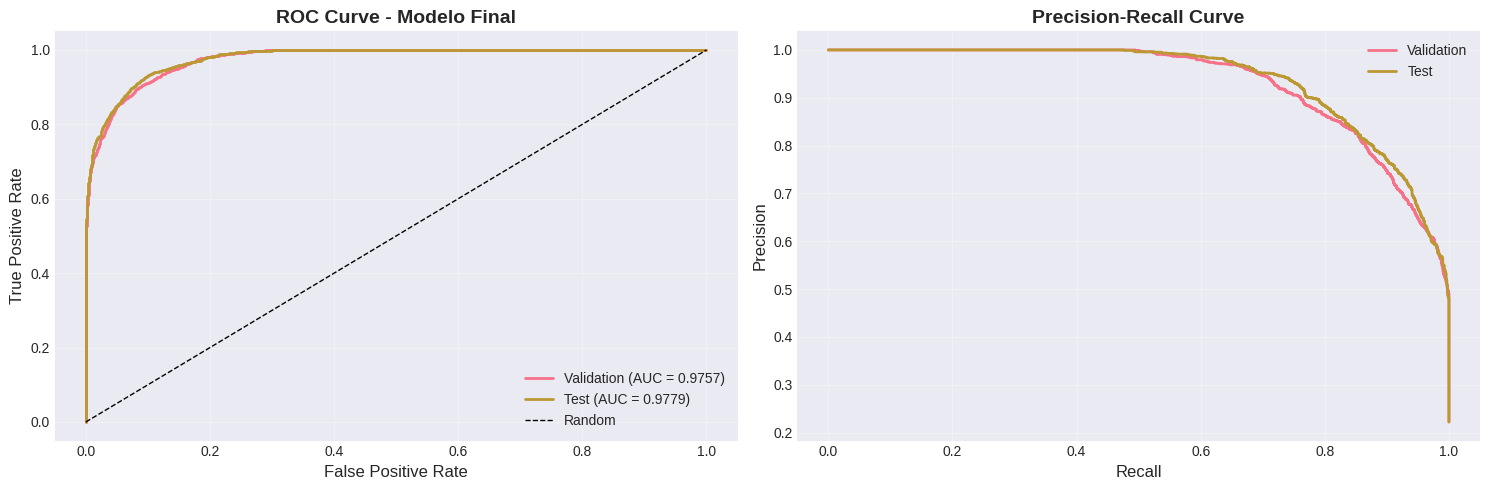

In [28]:
# Figura 1: ROC y Precision-Recall Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {final_auc_val:.4f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {final_auc_test:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Modelo Final', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label='Validation', linewidth=2)
axes[1].plot(recall_test, precision_test, label='Test', linewidth=2)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# La curva ROC muestra una excelente capacidad de discriminación del modelo,
# con valores de AUC cercanos a 0.98 tanto en validación como en test.
# La similitud entre ambas curvas indica buen poder de generalización
# y ausencia de sobreajuste.

# La curva Precision-Recall confirma un desempeño robusto,
# manteniendo alta precisión incluso para valores elevados de recall.
# Esto resulta especialmente relevante para el caso de negocio,
# ya que permite identificar la mayoría de los casos positivos
# sin incrementar excesivamente los falsos positivos.


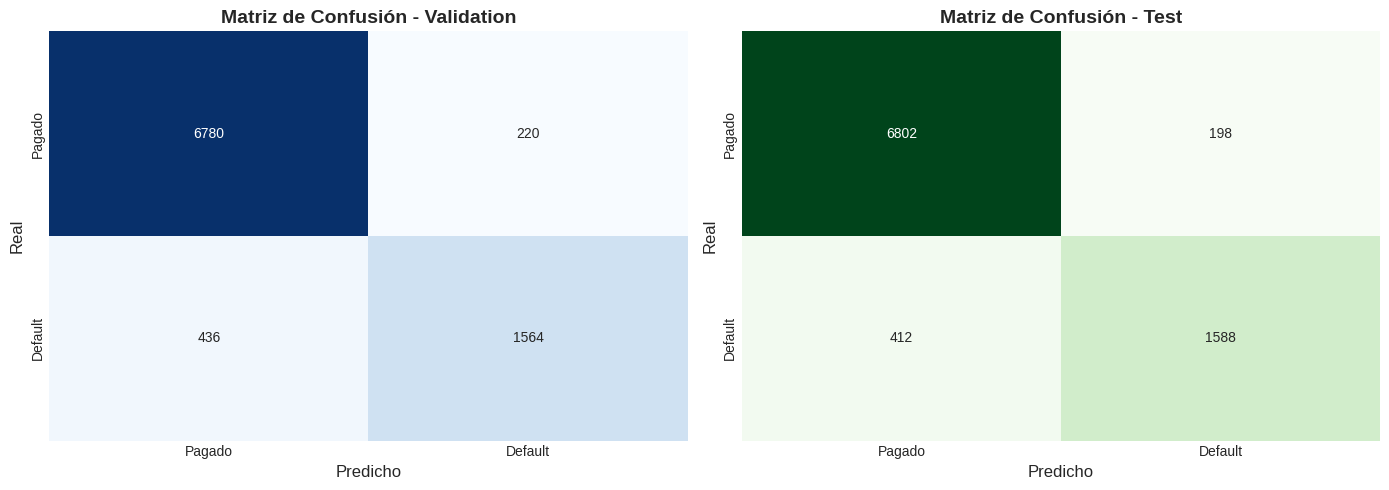

In [29]:
# Figura 2: Matrices de Confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Validation
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Matriz de Confusión - Validation', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Real', fontsize=12)
axes[0].set_xlabel('Predicho', fontsize=12)
axes[0].set_xticklabels(['Pagado', 'Default'])
axes[0].set_yticklabels(['Pagado', 'Default'])

# Test
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Matriz de Confusión - Test', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Real', fontsize=12)
axes[1].set_xlabel('Predicho', fontsize=12)
axes[1].set_xticklabels(['Pagado', 'Default'])
axes[1].set_yticklabels(['Pagado', 'Default'])

plt.tight_layout()
plt.show()

# Las matrices de confusión muestran un desempeño consistente
# entre validación y test, con una alta cantidad de verdaderos
# negativos y verdaderos positivos.

# El modelo logra identificar correctamente la mayoría de los casos
# de default, manteniendo bajo el número de falsos positivos.
# La similitud de los resultados entre ambos conjuntos
# refuerza la idea de buen poder de generalización.




TOP 10 FEATURES MÁS IMPORTANTES:
                                   feature  importance
16  previous_loan_defaults_on_file_encoded    0.797558
14           person_home_ownership_encoded    0.038743
9                              debt_burden    0.036516
1                            loan_int_rate    0.022080
8                     income_to_loan_ratio    0.021112
10                        credit_to_income    0.013642
2                            person_income    0.013595
15                     loan_intent_encoded    0.011837
4                             credit_score    0.006495
18                    income_level_encoded    0.005234




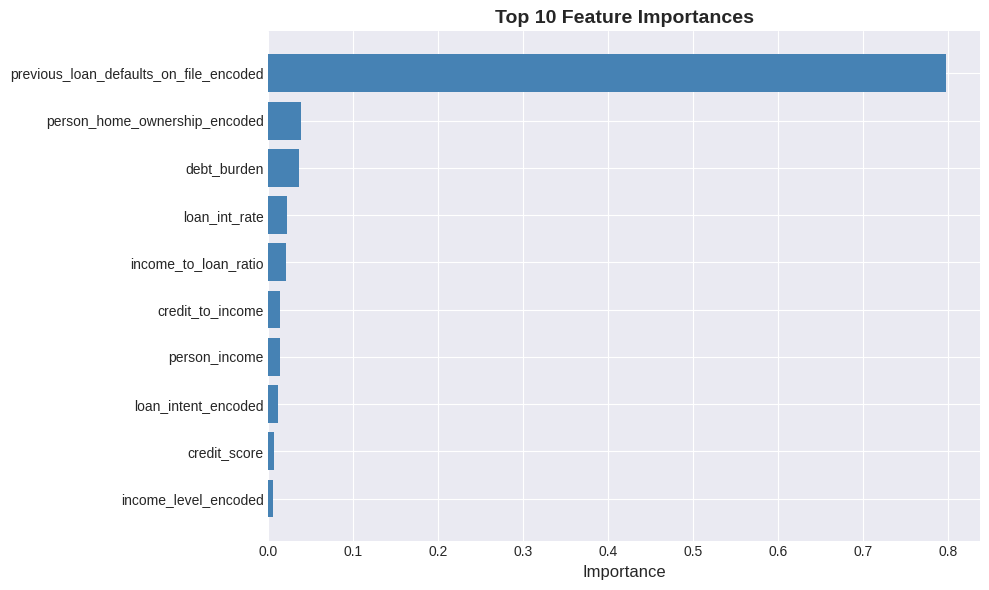

In [30]:
# Feature importance (si es tree-based)
if hasattr(final_model_optimized, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': final_model_optimized.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTOP 10 FEATURES MÁS IMPORTANTES:")
    print(feature_importance.head(10))
    print("\n")

    # Visualizar
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][:10][::-1],
             feature_importance['importance'][:10][::-1],
             color='steelblue')
    plt.xlabel('Importance', fontsize=12)
    plt.title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# El análisis de importancia de variables muestra que
# `previous_loan_defaults_on_file` es, por amplio margen,
# la feature más relevante del modelo, lo que resulta coherente
# con el comportamiento histórico de incumplimiento.

# El resto de las variables más importantes están asociadas
# al perfil financiero del solicitante (endeudamiento, ingresos,
# tasa de interés y ratios crédito/ingreso), lo que refuerza
# la interpretabilidad y consistencia del modelo con el caso de negocio.


### 11. Guardar el modleo final y objetos necesarios

In [31]:
# Crear diccionario con todo lo necesario
model_package = {
    'model': final_model_optimized,
    'scaler': scaler,
    'feature_names': feature_cols,
    'best_params': grid_search.best_params_,
    'model_name': best_model_name,
    'metrics_val': {
        'roc_auc': final_auc_val,
        'f1': final_f1_val,
        'precision': final_precision_val,
        'recall': final_recall_val
    },
    'metrics_test': {
        'roc_auc': final_auc_test,
        'f1': final_f1_test,
        'precision': final_precision_test,
        'recall': final_recall_test
    }
}


In [32]:
# Guardar todo en un solo archivo
with open('model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Modelo completo guardado en 'model_package.pkl'")

Modelo completo guardado en 'model_package.pkl'


In [33]:
# También guardar componentes individuales para facilidad de uso
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model_optimized, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print("Componentes individuales guardados")

Componentes individuales guardados


In [34]:
# Guardar predictions en test
test_results = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred_proba': y_test_pred_proba,
    'y_pred': y_test_pred
})
test_results.to_csv('test_predictions.csv', index=False)
print("Predicciones de test guardadas en 'test_predictions.csv'")

Predicciones de test guardadas en 'test_predictions.csv'
